# ACCESS-OM3 SSS and SSS difference from WOA23

Related issue: https://github.com/ACCESS-Community-Hub/access-om3-25km-paper-1/issues/10

In [6]:
#parameters

### USER EDIT start
esm_file='/g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json'
plotfolder='/g/data/tm70/cyb561/access-om3-paper-1/notebooks/mkfigs_output/2/'
dpi=300
### USER EDIT stop

import matplotlib as mpl
import os
%matplotlib inline
mpl.rcParams['figure.dpi']= dpi

os.makedirs(plotfolder, exist_ok=True)

 # a similar cell under this means it's being run in batch
print("ESM datastore path: ",esm_file)
print("Plot folder path: ",plotfolder)

MC_25km_jra_ryf-1.0-beta
ESM datastore path:  /g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json
Plot folder path:  /g/data/tm70/cyb561/access-om3-paper-1/notebooks/mkfigs_output/2/


In [1]:
import xarray as xr
import cf_xarray as cfxr
import cf_xarray.units
import pint_xarray
from pint import application_registry as ureg
import intake
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from distributed import Client
import cftime
import os
import matplotlib.pyplot as plt
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
from textwrap import wrap
xr.set_options(keep_attrs=True);  # cf_xarray works best when xarray keeps attributes by default

In [2]:
client = Client(threads_per_worker=1)
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42587 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/42587/status,
Dashboard: /proxy/42587/status,Workers: 14
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39415,Workers: 0
Dashboard: /proxy/42587/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:34467,Total threads: 1
Dashboard: /proxy/33405/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:44675,


### Define plot function

In [3]:
blue_marble = plt.imread('/g/data/ik11/grids/BlueMarble.tiff')
blue_marble_extent = (-180, 180, -90, 90)

In [4]:
def plot(dat, title=None, **kwargs):
    if title is None:
        title = dat.attrs['long_name']
    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.Robinson(central_longitude=-100))
    dat.plot.contourf(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cbar_kwargs={"label": "\n".join(wrap(f"{dat.attrs['long_name']} [{dat.attrs['units']}]", 45)),
                     "fraction": 0.03, "aspect": 15, "shrink": 0.7},
        **kwargs
    )
    
    # Add blue marble land:
    ax.imshow(
        blue_marble, extent=blue_marble_extent, transform=ccrs.PlateCarree(), origin="upper"
    )
    
    plt.title(title);

### Load and plot sea surface temperature from ACCESS-OM3

In [5]:
#exptname = "MC_25km_jra_ryf-1.0-beta"
exptname=os.path.basename(os.path.dirname(esm_file))

#old esm_file f"/g/data/ol01/access-om3-output/access-om3-025/{exptname}/experiment_datastore.json"

datastore = intake.open_esm_datastore(
    esm_file,
    columns_with_iterables=[
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
    ]
)

In [6]:
geolon = datastore.search(variable="geolon").to_dask().geolon
geolat = datastore.search(variable="geolat").to_dask().geolat

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/intake_esm/source.py:280: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/intake_esm/source.py:280: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(


In [7]:
variable = "sos"
model = datastore.search(variable=variable, frequency="1day").to_dask(
    xarray_open_kwargs = dict(
        chunks={"time": -1},
        decode_timedelta=True
    ),
    xarray_combine_by_coords_kwargs=dict(
        compat="override",
        data_vars="minimal",
        coords="minimal"
    )
)[variable].cf.assign_coords({ "longitude": geolon, "latitude": geolat })

In [8]:
model.time.values[-1] # to check final date

cftime.DatetimeNoLeap(1951, 12, 31, 12, 0, 0, 0, has_year_zero=True)

In [9]:
# set time range: last 10 years
timerange = slice(cftime.DatetimeNoLeap(1942, 1, 1, 0, 0, 0, 0),
                  cftime.DatetimeNoLeap(1952, 1, 1, 0, 0, 0, 0))

In [10]:
%%time
model = model.sel(time=timerange).mean('time').load()

CPU times: user 9.82 s, sys: 2.16 s, total: 12 s
Wall time: 1min 19s


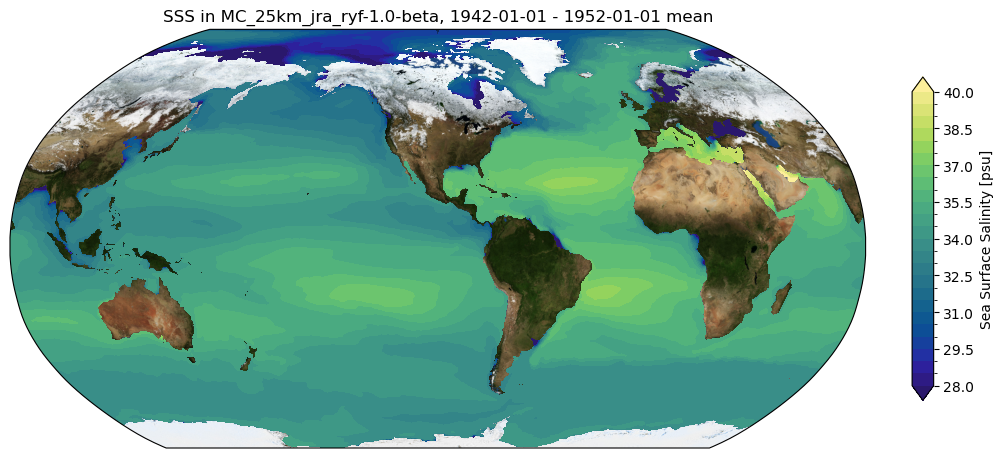

In [11]:
plot(model,
    levels=25,
    vmin=28,
    vmax=40,
    extend="both",
    cmap=cm.cm.haline,
    title=f"SSS in {exptname}, {timerange.start.strftime('%Y-%m-%d')} - {timerange.stop.strftime('%Y-%m-%d')} mean"
    )

### Load sea surface salinity from WOA23 (annual mean; Jan is ACCESS-OM3 initial condition)

In [12]:
obs = xr.open_mfdataset('/g/data/ik11/inputs/access-om3/woa23/025/woa23_ts_*', 
                            chunks={'time': -1})['salt'].isel(depth=0).mean('time').rename({'lat': 'yh', 'lon': 'xh'}).load()
obs = obs.cf.assign_coords({ "longitude": geolon, "latitude": geolat })

In [13]:
# bug fix: force coords to match model output https://github.com/ACCESS-NRI/access-om3-configs/issues/683
obs = obs.cf.assign_coords({ 'yh': model['yh'], 'xh': model['xh'] })

### Plot ACCESS-OM3 SSS minus WOA23
First plot full range, then a sequence at specified ranges.

In [14]:
bias = (model - obs).load().cf.assign_coords({ "longitude": geolon, "latitude": geolat })

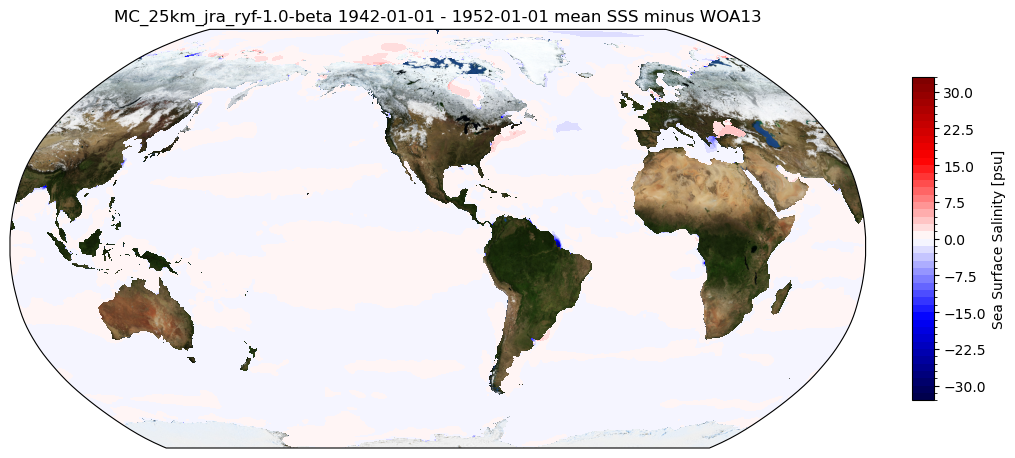

In [15]:
plot(bias,
    levels=51,
    cmap='seismic',
    title=f"{exptname} {timerange.start.strftime('%Y-%m-%d')} - {timerange.stop.strftime('%Y-%m-%d')} mean SSS minus WOA13"
    )

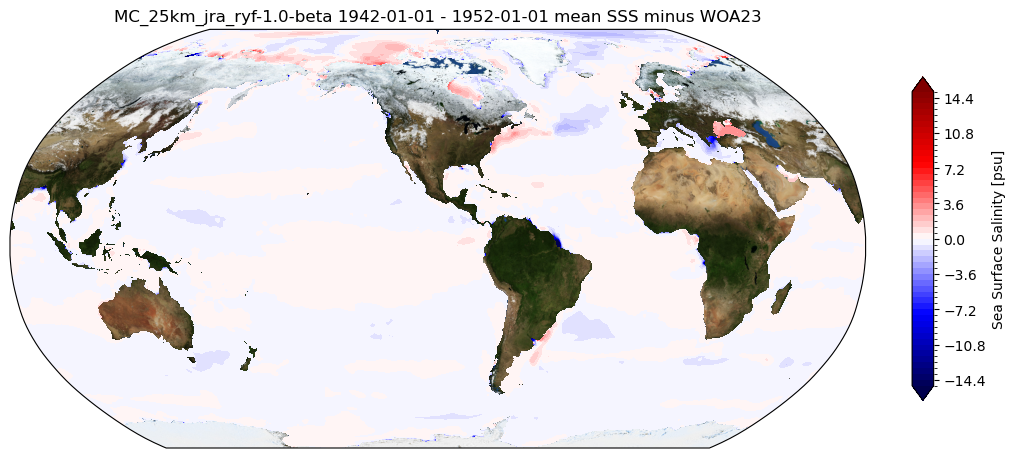

In [16]:
plot(bias,
    levels=51,
    vmin=-15,
    vmax=15,
    extend="both",
    cmap='seismic',
    title=f"{exptname} {timerange.start.strftime('%Y-%m-%d')} - {timerange.stop.strftime('%Y-%m-%d')} mean SSS minus WOA23"
    )

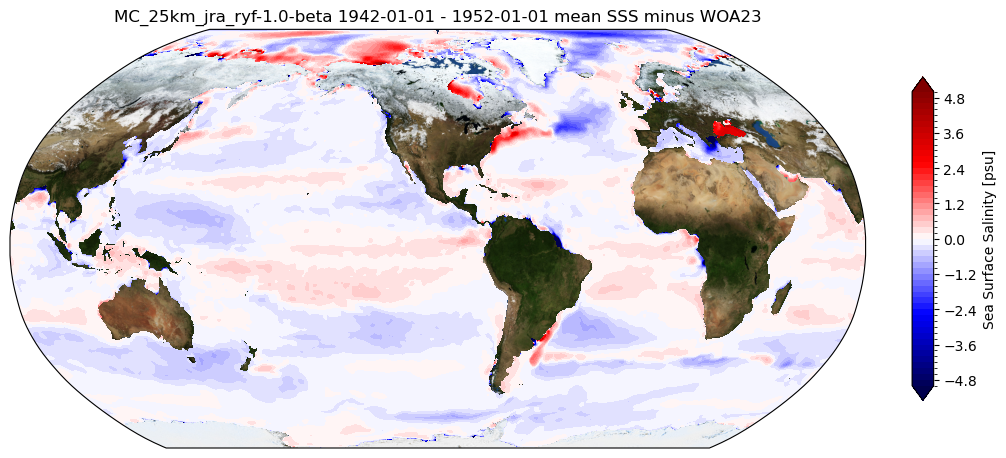

In [17]:
plot(bias,
    levels=51,
    vmin=-5,
    vmax=5,
    extend="both",
    cmap='seismic',
    title=f"{exptname} {timerange.start.strftime('%Y-%m-%d')} - {timerange.stop.strftime('%Y-%m-%d')} mean SSS minus WOA23"
    )

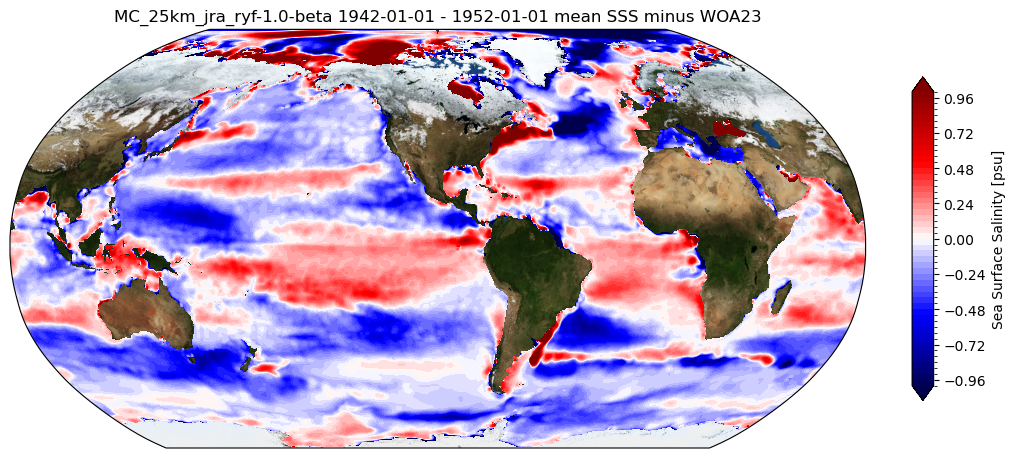

In [18]:
plot(bias,
    levels=51,
    vmin=-1,
    vmax=1,
    extend="both",
    cmap='seismic',
    title=f"{exptname} {timerange.start.strftime('%Y-%m-%d')} - {timerange.stop.strftime('%Y-%m-%d')} mean SSS minus WOA23"
    )

In [19]:
client.close()